### Survival on titanic
This notebook carries out a little bit more analysis compared to the *explo-notebook* including the introduction of new features based on existing ones, recursive feature elimination, class imbalance accounting (not yet) and feature relevance, i.a.



In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

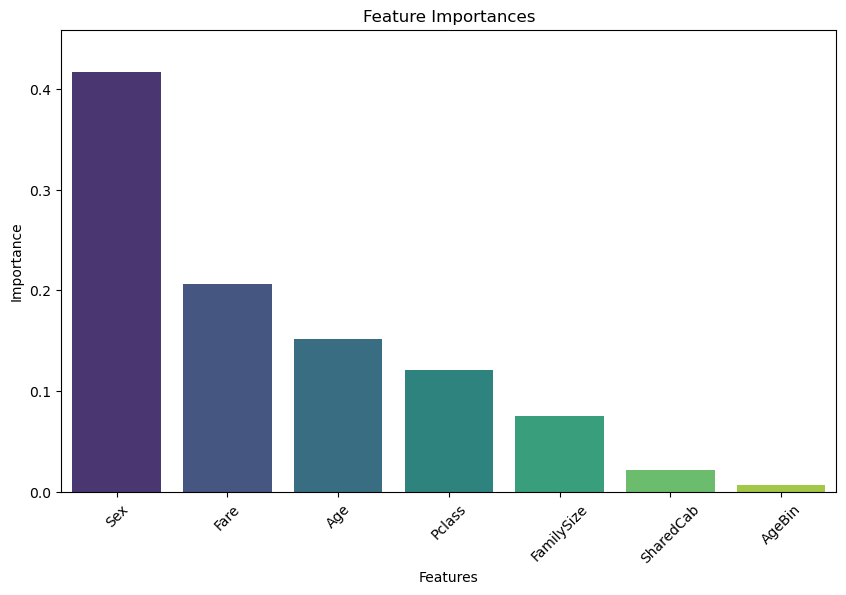

In [4]:
from warnings import filterwarnings
filterwarnings('ignore')


# 1. Data Preprocessing
def preprocess_data(df):
    # Handle missing values
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    
    # Extract title from name
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    # Create family size feature
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # Create is_alone feature
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
    
    # Create age bins
    df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 60, 80])
    
    # Create fare bins
    df['FareBin'] = pd.qcut(df['Fare'], q=4)
    
    # Create bool indicating a shared cabin between passengers
    df['SharedCab'] = df['Cabin'].apply(lambda x: 1 if pd.notna(x) and df['Cabin'].value_counts()[x] > 1 else 0)
    
    # Create a boolean family feature # thanks to the post on medium by Tim Chan for the idea
    df['Surname'] = df['Name'].str.extract(r'([A-Za-z]+),', expand=False)
    df['TixPref'] = df.Ticket.str.extract(r'(.*\d)', expand=False)
    df['Family'] = df['TixPref'] + df['Surname']
    df['Family'] = df['Family'].duplicated(keep=False).astype(int)
    
    # Encode categorical variables
    categorical_features = ['Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin']
    for feature in categorical_features:
        df[feature] = pd.factorize(df[feature])[0]

    
    return df

# 2. Feature Selection
def select_features(X, y, n_features=10):
    rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=n_features, verbose=0)
    rfe = rfe.fit(X, y)
    return X.columns[rfe.support_]

# 3. Model Training and Evaluation
def train_and_evaluate_model(X, y, **kwargs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {
        'RandomForest': RandomForestClassifier(**kwargs, bootstrap=True, criterion='entropy', min_samples_leaf=5, min_samples_split=2),
        'GradientBoosting': GradientBoostingClassifier(**kwargs),
        'XGBoost': XGBClassifier(**kwargs, bootstrap=True),
        'LightGBM': LGBMClassifier(**kwargs)
    }
    
    results = {}
    for name, model in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy', verbose=0)
        results[name] = scores.mean()
    
    best_model_name = max(results, key=results.get)
    
    # Train the best model on the full dataset
    best_model = Pipeline([
        ('scaler', StandardScaler()),
        ('model', models[best_model_name])
    ])
    best_model.fit(X, y)
    print(f"Best model: {best_model_name} with accuracy: {results[best_model_name]:.4f}")
    
    return best_model

def main():
    # Load data
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    
    # Store indices
    test_indices = test_data.index
    train_indices = train_data.index
    
    # Extract target variable
    y = train_data['Survived']
    
    # Preprocess data
    data = pd.concat([train_data.drop(['Survived'], axis=1), test_data], axis=0)
    data = preprocess_data(data)
    data = data.drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 'Surname', 'TixPref', 'Title'], axis=1)
    
    # Separate features and target
    X = data.iloc[train_indices]
    test_data = data.iloc[test_indices]
    
    # Select features
    selected_features = select_features(X, y, n_features=7)
    X = X[selected_features]
    
    # Train and evaluate model
    best_model = train_and_evaluate_model(X, y, n_estimators=250, random_state=42)
    
    # Prepare test data
    test_X = test_data[selected_features]
    
    # Make predictions
    predictions = best_model.predict(test_X)
    
    # Create submission file
    test_data['PassengerId'] = range(892, 892 + len(test_data))
    submission = pd.DataFrame({
        'PassengerId': test_data['PassengerId'],
        'Survived': predictions
    })
    submission.to_csv('submission.csv', index=False)
    print("Submission file created successfully.")
        
    # Extract the actual model from the pipeline
    model = best_model.named_steps['model']

    # Calculate feature importances
    importance = pd.DataFrame({'feature': X.columns, 'importance': np.round(model.feature_importances_, 3)})
    importance = importance.sort_values('importance', ascending=False).set_index('feature')

    # Plotting with seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance.index, y=importance['importance'], palette='viridis')
    plt.title('Feature Importances')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.ylim(0, importance['importance'].max() * 1.1)  # Set y-axis limits
    plt.show();

if __name__ == "__main__":
    main()

Best model: GradientBoost with accuracy: 0.8462 with 7 features and 250 estimators.

The range of accuracies is centered around this area, meaning they do not outperform one another by a large proportion.

The title is likely too strong and the model did not seem to learn the other features well! This is shown by sex being less important than the family size. An easy explanation is confounding the title with sex and age (although they are redundant in some way). So, we must not infer a causal explanation to the importance of features! 

This is easily seen upon removal of the feature and a resulting accuracy of 84.07 with Sex being most important.

